In [2]:
import random
from collections import deque
from typing import List

RANKS = [2,3,4,5,6,7,8,9,10,10,10,10,11] # Using 11 for Ace for now
PLAYER = 15
DEALER = 9
INFINITE = True

In [3]:
def hand_value(cards):
   total = sum(cards)
   # Adjust for Aces
   aces = cards.count(11)
   is_soft = False
   while total > 21 and aces:
      total -= 10
      aces -= 1
   if any(c == 11 for c in cards) and total <= 21:
      is_soft = True
   return total, is_soft  # a soft ace means one counted as 11

def make_deck(num_decks=6):
   single = []
   for _ in range(4 * num_decks):
      single.extend([2,3,4,5,6,7,8,9,10,10,10,10,11])
   deck = deque(single)
   random.shuffle(deck)
   return deck

def draw_card(deck, infinite, num_decks):
   # infinite deck: sampling with replacement / finite: real casino deck
   if infinite:
      return random.choice(RANKS)
   else:
      if not deck:
         deck = make_deck(num_decks)
      return deck.popleft()


In [4]:
def strategy_func(player_total, is_soft, dealer_upcard):
   # Basic strategy simplified for demonstration purposes
   if is_soft:
      if player_total <= 16:
         return 'HIT'

      if player_total == 17:
         return "HIT" if dealer_upcard in [9,10,11] else "STAND"

   else:
        if player_total >= 17:
            return "STAND"

        if 13 <= player_total <= 16:
            if dealer_upcard in [2,3,4,5,6]:
                return "STAND"
            else:
                return "HIT"

        if player_total == 12:
            if dealer_upcard in [4,5,6]:
                return "STAND"
            else:
                return "HIT"

        # Hard 5–11
        return "HIT"

def play_player(deck, player_cards, dealer_upcard, infinite, num_decks):
   # Execute ONE hit for the player, then get strategy decision again from strategy_func
   card = draw_card(deck, infinite, num_decks)
   player_cards.append(card)
   total, is_soft = hand_value(player_cards)
   
   next_move = strategy_func(total, is_soft, dealer_upcard)
   while next_move == "HIT":
      card = draw_card(deck, infinite, num_decks)
      player_cards.append(card)
      total, is_soft = hand_value(player_cards)
      if total > 21:
         break
      next_move = strategy_func(total, is_soft, dealer_upcard)
   return total

def play_dealer(dealer, deck, infinite, num_decks, player_total):
   # Dealer must hit on 16 or less, stand on 17 or more
   while hand_value(dealer)[0] < 17:
      dealer.append(draw_card(deck, infinite, num_decks))

   dealer_total, _ = hand_value(dealer)
   
   if dealer_total > 21:
      return 1  # Dealer busted, player wins

   if player_total > dealer_total:
      return 1
   elif player_total < dealer_total:
      return -1
   else:
      return 0 # push

def simulate_once(player_cards, dealer_upcard, deck, infinite, num_decks, decision):
   player = player_cards.copy()
   dealer = [dealer_upcard]
   
   if sum(player) == 21:
      decision = "STAND"  # Auto-stand on blackjack

   if decision == "HIT":
      player_total = play_player(deck, player, dealer_upcard, infinite, num_decks)
      if player_total > 21:
         return -1
   else: # STAND
      player_total, _ = hand_value(player)

   # Dealer's turn

   while hand_value(dealer)[0] < 17:
      dealer.append(draw_card(deck, infinite, num_decks))

   dealer_total, _ = hand_value(dealer)
   
   if dealer_total > 21:
      return 1  # Dealer busted, player wins

   if player_total > dealer_total:
      return 1
   elif player_total < dealer_total:
      return -1
   else:
      return 0 # push


In [5]:
def estimate_ev(player_cards: List[int], dealer_upcard: int,
               num_simulations: int = 1000000, infinite: bool = False, num_decks: int = 6, decision: str="HIT") -> float:

   # decision is either 'HIT' or 'STAND'
   wins = 0
   losses = 0
   pushes = 0
   results = []

   deck = make_deck(num_decks)

   for _ in range(num_simulations):

      # For simplicity, reshuffle every 10 hands
      if _ % 10 == 0:  
        deck = make_deck(num_decks)

      result = simulate_once(player_cards, dealer_upcard, deck, infinite, num_decks, decision)
      results.append(result)
      if result == 1:
         wins += 1
      elif result == -1:
         losses += 1
      else:
         pushes += 1

   ev = sum(results) / num_simulations

   return {
           "ev": ev,
           "win_rate": wins / num_simulations,
           "loss_rate": losses / num_simulations,
           "push_rate": pushes / num_simulations,
           "trails": num_simulations
   }

In [6]:
import matplotlib.pyplot as plt

def visualize_ev(player_cards, dealer_upcard, num_simulations=100000):
    """
    Run Monte Carlo simulations for HIT and STAND, then visualize with a bar chart.
    
    Args:
        player_cards: list of player's cards (e.g., [10, 5])
        dealer_upcard: dealer's visible card (e.g., 9)
        num_simulations: number of Monte Carlo trials
    """
    # Run simulations
    hit_result = estimate_ev(player_cards, dealer_upcard, num_simulations, infinite=True, decision="HIT")
    stand_result = estimate_ev(player_cards, dealer_upcard, num_simulations, infinite=True, decision="STAND")
    
    # Extract EVs
    hit_ev = hit_result["ev"]
    stand_ev = stand_result["ev"]
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    decisions = ["HIT", "STAND"]
    evs = [hit_ev, stand_ev]
    colors = ["#2ecc71" if ev > 0 else "#e74c3c" for ev in evs]
    
    bars = ax.bar(decisions, evs, color=colors, alpha=0.7, edgecolor="black", linewidth=2)
    
    # Add value labels on bars
    for bar, ev in zip(bars, evs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{ev:.4f}',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=12, fontweight='bold')
    
    # Labels and title
    player_total, _ = hand_value(player_cards)
    ax.set_ylabel("Expected Value (EV)", fontsize=12, fontweight='bold')
    ax.set_title(f"Player {player_total} vs Dealer {dealer_upcard} ({num_simulations:,} simulations)", 
                 fontsize=14, fontweight='bold')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_ylim(min(evs) - 0.1, max(evs) + 0.15)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Pie charts for win/loss/push rates
    labels = ['Wins', 'Losses', 'Pushes']
    hit_sizes = [hit_result['win_rate'], hit_result['loss_rate'], hit_result['push_rate']]
    stand_sizes = [stand_result['win_rate'], stand_result['loss_rate'], stand_result['push_rate']]
    colors_pie = ['#2ecc71', '#e74c3c', '#f1c40f']
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.pie(hit_sizes, labels=labels, autopct='%1.1f%%', colors=colors_pie, startangle=140)
    ax1.set_title('HIT Outcome Distribution', fontsize=14, fontweight='bold')
    ax2.pie(stand_sizes, labels=labels, autopct='%1.1f%%', colors=colors_pie, startangle=140)
    ax2.set_title('STAND Outcome Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    
    # Print summary
    print(f"\nPlayer: {player_cards} (Total: {player_total})")
    print(f"Dealer Upcard: {dealer_upcard}")
    print(f"\nHIT  → EV: {hit_ev:.4f}, Win Rate: {hit_result['win_rate']:.2%}, Loss Rate: {hit_result['loss_rate']:.2%}, Push Rate: {hit_result['push_rate']:.2%}")
    print(f"STAND → EV: {stand_ev:.4f}, Win Rate: {stand_result['win_rate']:.2%}, Loss Rate: {stand_result['loss_rate']:.2%}, Push Rate: {stand_result['push_rate']:.2%}")
    print(f"\nRecommendation: {'HIT' if hit_ev > stand_ev else 'STAND' if stand_ev > hit_ev else 'PUSH'}")
    

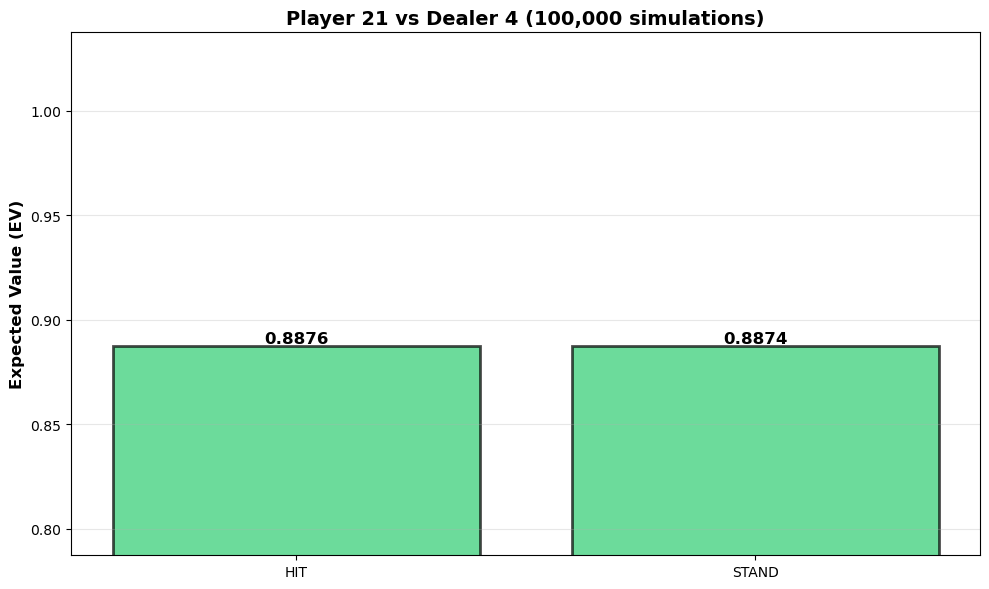

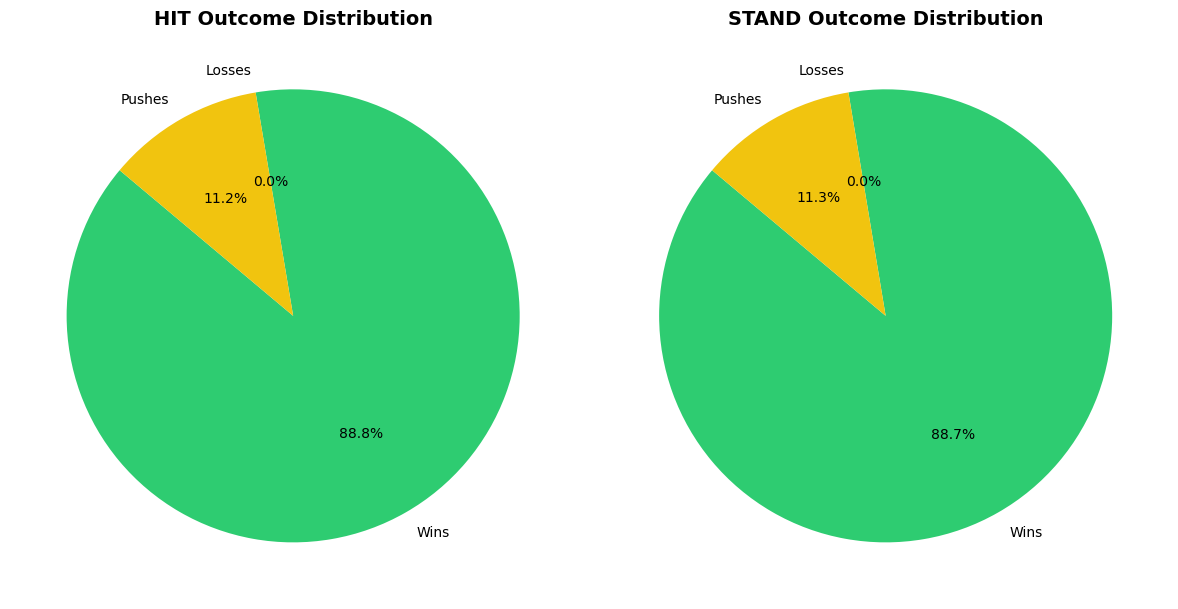


Player: [10, 11] (Total: 21)
Dealer Upcard: 4

HIT  → EV: 0.8876, Win Rate: 88.76%, Loss Rate: 0.00%, Push Rate: 11.24%
STAND → EV: 0.8874, Win Rate: 88.74%, Loss Rate: 0.00%, Push Rate: 11.26%

Recommendation: HIT


In [7]:
if __name__ == "__main__":
   player_cards = [10,11]
   dealer_upcard = 4
   trials = 100000

   visualize_ev(player_cards, dealer_upcard, trials)